Filename: LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    289   435R x 3C   [D, D, D]   
  2  SCI           1 ImageHDU       279   (435, 31)   float64   
  3  WHT           1 ImageHDU       279   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       279   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, D, D]   
None
Filename: LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    304   435R x 4C   [D, D, D, D]   
  2  SCI           1 ImageHDU       291   (435, 31)   float64   
  3  WHT           1 ImageHDU       291   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       291   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, 

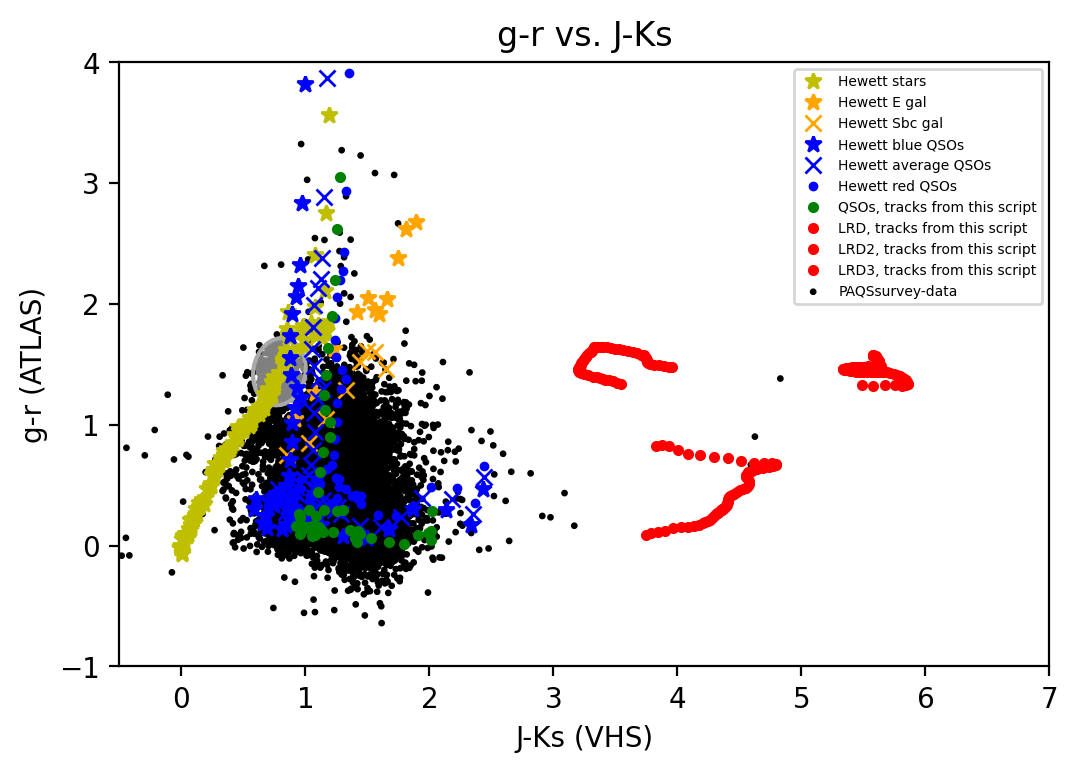

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spectres import spectres
import scipy.integrate as spi
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from astropy.io import fits

def LYMAN_BLANKET(lambd, z):
    #Based on Madau https://articles.adsabs.harvard.edu/pdf/1995ApJ...441...18M
    import numpy as np
    nl = 8
    p = 3.46
    npts = len(lambd)
    y = np.zeros((npts, nl), dtype=float)
    lyman = 1. - 1/(np.arange(nl) + 2)**2
    a = np.array([-0.00360, -0.00170, -0.00120, -0.00093,
                  -0.00090, -0.00087, -0.00085, -0.00080])

    c = 0.
    for i in range(nl):
        c += a[i] * ((1+z) * lyman[i])**p
    c = np.exp(c)

    lyman = 911.753 / lyman

    for i in range(nl):
        y[:, i] = a[i] * (lambd / lyman[i])**p * (lambd <= (1+z) * lyman[i])
    y = np.exp(nl * np.sum(y, axis=1) / npts)

    q = np.where(lambd <= (1+z) * lyman[nl-1])
    if len(q[0]) > 0:
        y[q] = c * np.exp(-0.0015 * z * ((1+z) * lyman[nl-1] - lambd[q]))

    return y


#Read transmission curves for g, r, J, Ks
tab = np.loadtxt('SDSS_g.data')
wave_g = tab[:,0]
transm_g = tab[:,1]

tab = np.loadtxt('SDSS_r.data')
wave_r = tab[:,0]
transm_r = tab[:,1]

tab = np.loadtxt('J_UKIRT.dat')
wave_J = 10.*tab[:,0]
transm_J = tab[:,1]/100.
wave_J = wave_J[::-1]
transm_J = transm_J[::-1]

tab = np.loadtxt('K_UKIRT.dat')
wave_Ks = 10.*tab[:,0]
transm_Ks = tab[:,1]/100.
wave_Ks = wave_Ks[::-1]
transm_Ks = transm_Ks[::-1]

#Filter characteristics from Hewett table 7
lamdacen_g = 4670.
lambdacen_r = 6156.
lambdacen_J = 1248.
lambdacen_Ks = 2201.
ABoff_g = -0.103
ABoff_r = 0.146
ABoff_J = 0.938
ABoff_Ks = 1.900

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]


#Read spectrum of vega
tab = np.loadtxt('vega.dat')
wave_vega = tab[:,0]
spec_vega = tab[:,1]*1.e17


#Integrate the fluxes of vega in the four filters
spec_vega_resample_g =  spectres(wave_g,wave_vega,spec_vega*wave_vega)
gvega = spi.simps(spec_vega_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
spec_vega_resample_r =  spectres(wave_r,wave_vega,spec_vega*wave_vega)
rvega = spi.simps(spec_vega_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
spec_vega_resample_J =  spectres(wave_J,wave_vega,spec_vega*wave_vega)
Jvega = spi.simps(spec_vega_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
spec_vega_resample_Ks =  spectres(wave_Ks,wave_vega,spec_vega*wave_vega)
Ksvega = spi.simps(spec_vega_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)

  
    
#Read LRD spectra
z = 3.438
#from 1.1 to 1.6
HDU = fits.open('LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd1 = spec1d.wave*10000./(1+z)
spec_lrd1 = spec1d.flux*(wave_lrd1/10000.)**2
z = 5.05
#from 1.9 to 2.5
HDU = fits.open('LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd2 = spec1d.wave*10000./(1+z)
spec_lrd2 = spec1d.flux/(wave_lrd2/10000.)**2
z=4.53
#from 1.7 to 2.3
HDU = fits.open('LRD/macsj0647-v2_prism-clear_1433_1045.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd3 = spec1d.wave*10000./(1+z)
spec_lrd3 = spec1d.flux*(wave_lrd3/10000.)**2

#For each z in the interval from 1.1 to 1.6 calculate the g-r and J-Ks colours for the LRD
gr_lrd1 = np.empty(76, dtype=float)
JKs_lrd1 = np.empty(76, dtype=float)
for nz in range(0,76):
    z = float(nz)/100.+1.16
    wave_lrd_z = wave_lrd1*(1.+z)
    spec_lrd = spec_lrd1*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd1[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd1[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)
gr_lrd2 = np.empty(65, dtype=float)
JKs_lrd2 = np.empty(65, dtype=float)
for nz in range(0,65):
    z = float(nz)/100.+2.1
    wave_lrd_z = wave_lrd2*(1.+z)
    spec_lrd = spec_lrd2*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd2[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd2[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)
gr_lrd3 = np.empty(65, dtype=float)
JKs_lrd3 = np.empty(65, dtype=float)
for nz in range(0,65):
    z = float(nz)/100.+1.7
    wave_lrd_z = wave_lrd3*(1.+z)
    spec_lrd = spec_lrd3*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd3[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd3[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)


#For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours in AB
gr = np.empty(60, dtype=float)
JKs = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = spec_qso*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

#Read Hewett et al. 
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table8.dat')
gr_8 = tab[:,1]
JK_8 = tab[:,7]+tab[:,8]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table16.dat')
gr_16 = tab[:,2]
JK_16 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table17.dat')
gr_17 = tab[:,2]
JK_17 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table25.dat')
gr_25 = tab[:,2]
JK_25 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table26.dat')
gr_26 = tab[:,2]
JK_26 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table27.dat')
gr_27 = tab[:,2]
JK_27 = tab[:,8]+tab[:,9]


#PAQSsurverydata
data = np.loadtxt('PAQSsurveyphotometry.dat', skiprows=1)
ID = data[:,0]              #Rektascension fra GAIA kataloget
RA = data[:,1]              #Rektascension fra GAIA kataloget
Dec = data[:,2]             #Deklination fra GAIA kataloget

u_ATLAS = data[:,3]          # u-filter størrelsesklasse (ATLAS)
err_u_ATLAS = data[:,4]        # usikkerhed på u-filter størrelsesklasse (ATLAS)
g_ATLAS = data[:,5]          # g-filter størrelsesklasse (ATLAS)
err_g_ATLAS = data[:,6]        # usikkerhed på g-filter størrelsesklasse (ATLAS)
r_ATLAS = data[:,7]          # r-filter størrelsesklasse (ATLAS)
err_r_ATLAS = data[:,8]       # usikkerhed på r-filter størrelsesklasse (ATLAS)
i_ATLAS = data[:,9]         # i-filter størrelsesklasse (ATLAS)
err_i_ATLAS = data[:,10]       # usikkerhed på i-filter størrelsesklasse (ATLAS)
z_ATLAS = data[:,11]         # z-filter størrelsesklasse (ATLAS)
err_z_ATLAS = data[:,12]       # usikkerhed på z-filter størrelsesklasse (ATLAS)
g_DES = data[:,13]
err_g_DES = data[:,14]
r_DES = data[:,15]
err_r_DES = data[:,16]
i_DES = data[:,17]
err_i_DES = data[:,18]
z_DES = data[:,19]
err_z_DES = data[:,20]
y_DES = data[:,21]
err_y_DES = data[:,22]
y_VHS = data[:,23]
err_y_VHS = data[:,24]
j_VHS = data[:,25]
err_j_VHS = data[:,26]
h_VHS = data[:,27]
err_h_VHS = data[:,28]
ks_VHS = data[:,29]
err_ks_VHS = data[:,30]

#Lav farve-farve plottet
errlim = 0.1
good = np.where((err_g_ATLAS < errlim) & (err_r_ATLAS < errlim) & (err_j_VHS < errlim) & (err_ks_VHS < errlim))

plt.figure(dpi=200)
x=j_VHS[good]-ks_VHS[good]    # VEGA
y=g_ATLAS[good]-r_ATLAS[good] # AB

plt.title('g-r vs. J-Ks')
plt.xlabel('J-Ks (VHS)')
plt.ylabel('g-r (ATLAS)')

#plt.plot(x,y,'o',color='black',markersize=2.5,label='PAQSsurvey_data')
plt.plot(JK_8, gr_8, '*',color='y', label='Hewett stars')
plt.plot(JK_16, gr_16, '*',color='orange', label='Hewett E gal')
plt.plot(JK_17, gr_17, 'x',color='orange', label='Hewett Sbc gal')
plt.plot(JK_25, gr_25, '*',color='b', label='Hewett blue QSOs')
plt.plot(JK_26, gr_26, 'x',color='b', label='Hewett average QSOs')
plt.plot(JK_27, gr_27, 'o',color='b', markersize=2.5, label='Hewett red QSOs')
plt.plot(JKs, gr, '.',color='g', label='QSOs, tracks from this script')
plt.plot(JKs_lrd1, gr_lrd1, '.',color='r', label='LRD, tracks from this script')
plt.plot(JKs_lrd2, gr_lrd2, '.',color='r', label='LRD2, tracks from this script')
plt.plot(JKs_lrd3, gr_lrd3, '.',color='r', label='LRD3, tracks from this script')


#plt.xlim(-0.3,2.6)
#plt.ylim(-0.6,2.2)

plt.xlim(-0.5,7)
plt.ylim(-1,4)

# Ellipse til stjerner
s_ell_center = (0.79, 1.44)
s_ell_width = 0.42
s_ell_height = 0.56
s_angle=350
s_ellipse = patches.Ellipse(s_ell_center, s_ell_width, s_ell_height, angle=s_angle, fill=False, edgecolor='darkgrey', linewidth=1.5)

ax = plt.gca()

ax.add_patch(s_ellipse)

cos_angle_s = np.cos(np.radians(180.-s_angle))
sin_angle_s = np.sin(np.radians(180.-s_angle))

xc_s = x - s_ell_center[0]
yc_s = y - s_ell_center[1]

xct_s = xc_s * cos_angle_s - yc_s * sin_angle_s
yct_s = xc_s * sin_angle_s + yc_s * cos_angle_s 

rad_cc_s = (xct_s**2/(s_ell_width/2.)**2) + (yct_s**2/(s_ell_height/2.)**2)

# Set the colors. Black if outside the ellipse, grey if inside
colors_array = []

for r in rad_cc_s:
    if r <= 1.:
        # point in star ellipse
        colors_array.append('grey')
    else:
        # point not in ellipse
        colors_array.append('black')
       
plt.scatter(x, y, c=colors_array,label='PAQSsurvey-data',s=2)


plt.legend(prop={'size':5})
plt.show()

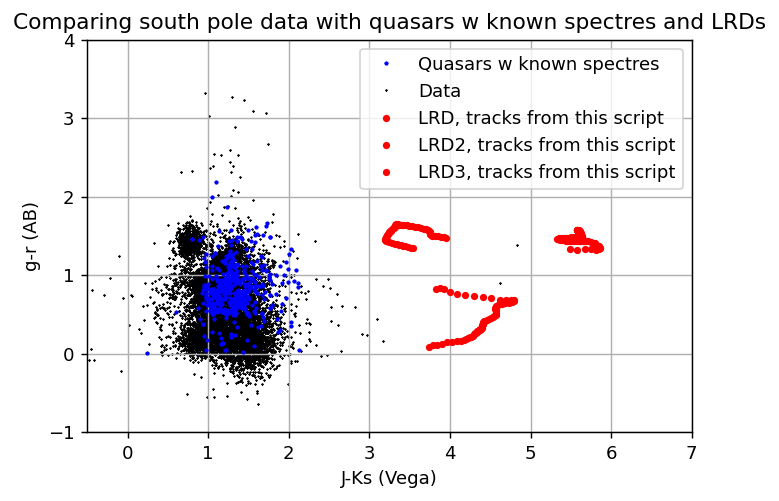

In [2]:
tab = np.genfromtxt('parentcat.csv', skip_header=1, delimiter=',', dtype=None, encoding=None)

name=[nested_arr[1] for nested_arr in tab]

g = [nested_arr[9] for nested_arr in tab]
g_array = np.array(g)
gerr = np.array([nested_arr[10] for nested_arr in tab])

r = [nested_arr[11] for nested_arr in tab]
r_array = np.array(r) 
rerr = np.array([nested_arr[12] for nested_arr in tab])

J = [nested_arr[19] for nested_arr in tab]
J_array = np.array(J) 
Jerr = np.array([nested_arr[20] for nested_arr in tab])

K = [nested_arr[23] for nested_arr in tab]
K_array = np.array(K) 
Kerr = np.array([nested_arr[24] for nested_arr in tab])

errlim = 0.1
good2 = np.where((rerr < errlim) & (gerr < errlim) & (Jerr < errlim) & (Kerr < errlim))

gr_known = g_array[good2] - r_array[good2]
JK_known = J_array[good2] - K_array[good2]


#Make plot 
plt.figure(dpi=130)
plt.grid()

plt.plot(JK_known,gr_known,color='b',label='Quasars w known spectres', marker='*',linestyle='', markersize=2)
plt.plot(x,y,color='black',linestyle='', marker='*', markersize=0.7, label='Data', zorder=1)
plt.plot(JKs_lrd1, gr_lrd1, '.',color='r', label='LRD, tracks from this script')
plt.plot(JKs_lrd2, gr_lrd2, '.',color='r', label='LRD2, tracks from this script')
plt.plot(JKs_lrd3, gr_lrd3, '.',color='r', label='LRD3, tracks from this script')

plt.title('Comparing south pole data with quasars w known spectres and LRDs')

#plt.xlim(0,2.5)
#plt.ylim(-0.5,2)

plt.xlim(-0.5,7)
plt.ylim(-1,4)

plt.xlabel('J-Ks (Vega)')
plt.ylabel('g-r (AB)')
plt.legend()
plt.show()


In [3]:
# Assuming x and y are arrays containing the coordinates of blue points and red points
# Here, x_black and y_black are arrays containing the x and y coordinates of black points
# Similarly, x_red and y_red are arrays containing the x and y coordinates of red points

# Calculate distances between each black point and each red point
distances = np.sqrt((JK_known[:, np.newaxis] - JKs_lrd1)**2 + (gr_known[:, np.newaxis] - gr_lrd1)**2)

# Find indices of the two blue points with the smallest distances to red points
closest_blue_indices = np.unravel_index(np.argsort(distances, axis=None)[:5], distances.shape)

# Get the coordinates of the two closest black points
closest_blue_points = [(JK_known[i], gr_known[i]) for i in closest_blue_indices[0]]
closest_blue_names = [name[i] for i in closest_blue_indices[0]]

print("Coordinates of the two closest blue points:", closest_blue_points)

Coordinates of the two closest blue points: [(2.088706, 1.0589499999999994), (2.088706, 1.0589499999999994), (2.025735000000001, 1.3291299999999993), (2.025735000000001, 1.3291299999999993), (2.088706, 1.0589499999999994)]


In [4]:
print("Names of the two closest blue points:", closest_blue_names)

Names of the two closest blue points: ['eHAQ2316+0651', 'eHAQ2316+0651', 'eHAQ0142+0257', 'eHAQ0142+0257', 'eHAQ2316+0651']
